## Business Understanding
The San Francisco Controller's Office has maintained an Employee Compensation database since fiscal year 2013.
This salary and benefits data available in *.csv is summarized and presented on the Employee Compensation report at http://openbook.sfgov.org.

Compensation is important in any HR and city government's efforts to obtain, maintain, and retain an effective work force.
Tracking and measuring employee compensation ensures equity, cost control, and compliance to government regulations.
This enables designing compensation plans that compete with established labour markets, rewarding employee contributions
for desired results, promoting acquisition and upgrades of knowledge and skills, supporting team work, and increasing
workforce engagement to go the extra mile for the city organization.

Our task is to analyze the compensation data collected to-date so that the city can plan and forecast the costs of employee compensation for the next 5-10 years.

In [8]:
#Load libraries and import Employee Compensation df
import pandas as pd
import numpy as np
import sqlite3
import pandas_profiling
import rpy2
import rpy2.rinterface
import matplotlib.pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')
import warnings # current version of seaborn generates a bunch of warnings that we'll ignore
warnings.filterwarnings("ignore")
import seaborn as sns
#import rpy2.ipython

In [3]:
#Read in the data from the file
df = pd.read_csv('/Users/mtran/Documents/SMUDataSciences/2019-Summer/Employee_Compensation.csv')
print("Finished Loading Data.")

## Data Meaning Type

The compensation data set contains 831,992 rows and 22 attributes. The data definitions are 
Reference https://dev.socrata.com/foundry/data.sfgov.org/88g8-5mnd

Year Type: Fiscal (which indicates the Year range is July through June) or Calendar (which indicates the Year range is January through December)

Year: An accounting period of 12 months of which the start and end month is determined by ‘Year Type’.  The actual values are four digits long e.g. ‘2019’. The range is from ‘2013’ to ‘2019’.

Organization Group Code: This column is a numerical indicator of the ‘Organization Group’. The values range between 1 and 7 inclusive. They are integers.

Organization Group: This column is a grouping of Departments.

Department Code: A three character code that indicates the ‘Department’ e.g. ‘DPH’.

Department: The primary organizational unit used by the City and County of San Francisco. This is a string value e.g. ‘DPH Public Health’.

Union Code: An integer value that indicates a ‘Union’. The values are integers which range from 0 to 990 inclusive.

Union: Represent employees in collective bargaining agreements. The values are a string e.g. ‘SEIU, Local 1021, RN’

Job Family Code: A three to four character code that indicates the ‘Job Family’ e.g. ‘H000’.

Job Family: Combines similar Jobs into meaningful groups. This is a string value e.g. ‘Nursing’.

Job Code: A three to four character code that indicates the ‘Job’ e.g. P103.

Job: Defined by the Human Resources classification unit. This is a string value e.g. ‘Special Nurse’.

Employee Identifier: A 7 digit number that represents one employee e.g. ‘8592281’.

Salaries: Normal salaries paid to permanent or temporary City employees. A decimal dollar amount ranging from 0 to 631952.71.

Overtime: Amounts paid to City employees working in excess of 40 hours per week. A decimal dollar amount ranging from 0 to 309897.2.

Other Salaries: Various irregular payments made to City employees including premium pay, incentive 
pay, or other one-time payments. A decimal dollar amount ranging from 0 to 336726.34.

Total Salary: The sum of all salaries paid to City employees. A decimal dollar amount ranging from 0 to 637457.58.

Retirement: City contributions to employee retirement plans. A decimal dollar amount ranging from 0 to 118296.72.

Health and Dental: Pro-rated citywide average premiums to health and dental insurance plans (not employee-specific). A decimal dollar amount ranging from 0 to 22270.12.

Other Benefits: Mandatory benefits paid on behalf of employees, such as Social Security (FICA and Medicare) contributions, unemployment insurance premiums, and minor discretionary benefits. A decimal dollar amount ranging from 0 to 37198.6.

Total Benefits: The sum of all benefits paid to City employees. A decimal dollar amount ranging from 0 to 141920.27.

Total Compensation: The sum of all salaries and benefits paid to City employees. A decimal dollar amount ranging from 0 to 779377.85.

In [5]:
data_df.dtypes

Year Type                   object
Year                         int64
Organization Group Code      int64
Organization Group          object
Department Code             object
Department                  object
Union Code                 float64
Union                       object
Job Family Code             object
Job Family                  object
Job Code                    object
Job                         object
Employee Identifier          int64
Salaries                   float64
Overtime                   float64
Other Salaries             float64
Total Salary               float64
Retirement                 float64
Health and Dental          float64
Other Benefits             float64
Total Benefits             float64
Total Compensation         float64
dtype: object

In [ ]:
data_df.shape

In [ ]:
# Check for missing data
total = data_df.isnull().sum().sort_values(ascending = False)
percent = (data_df.isnull().sum() / data_df.isnull().count() * 100).sort_values(ascending = False)
pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent']).transpose()

## Data Quality

An initial exploration of the data quality suggested that we need to perform some cleaning to better determine and visualize meaningful information.

We decided to retain only rows with the fiscal year type, cutting the dataset rows by more than half to 333,594 rows; concluded the one row attributed to the year 2028 is a typo and removed it; deleted 1 row from where the value in the column 'Job' is null; visualized the salary and benefit attributes as percentages then deleted those rows with negative values; and imputed the union, job family, job family codes, department, department codes, and department values. 

Reference https://data.sfgov.org/City-Management-and-Ethics/Reference-Department-Code-List/j2hz-23ps/data

In [ ]:
#Save the dataframe into a new dataframe to clean
df_clean = df
#Keeps all of the Fiscal Year entries
df_clean = df_clean[df_clean['Year Type'] == 'Fiscal']
print(df_clean.info())

In [ ]:
#Get names of indexes for which column Year has value 2028
indexNames = df_clean.loc[df_clean['Year'] == 2028, 'Year'].index
# Delete these row indexes from dataFrame
df_clean.drop(indexNames, inplace = True)

In [ ]:
#Get names of indexes for which column Job is Null
indexNames = df_clean.loc[df_clean['Job'] == np.NaN, 'Year'].index
# Delete these row indexes from dataFrame
df_clean.drop(indexNames, inplace = True)

In [ ]:
#Deletes the 1 row missing the Job
indexNames = df_clean.loc[df_clean['Job'].isnull()].index
df_clean.drop(indexNames, inplace = True)
df_clean.describe()

In [ ]:
#Delete Salaries values with negatives
indexNames = df_clean.loc[df_clean['Salaries'] < 0, 'Salaries'].index
df_clean.drop(indexNames, inplace = True)

In [ ]:
#Delete Overtime values with negatives
indexNames = df_clean.loc[df_clean['Overtime'] < 0, 'Overtime'].index
df_clean.drop(indexNames, inplace = True)

In [ ]:
#Delete Other Salaries values with negatives
indexNames = df_clean.loc[df_clean['Other Salaries'] < 0, 'Other Salaries'].index
df_clean.drop(indexNames, inplace = True)

In [ ]:
#Delete Retirement values with negatives
indexNames = df_clean.loc[df_clean['Retirement'] < 0, 'Retirement'].index
df_clean.drop(indexNames, inplace = True)

In [ ]:
#Delete Health and Dental values with negatives
indexNames = df_clean.loc[df_clean['Health and Dental'] < 0, 'Health and Dental'].index
df_clean.drop(indexNames, inplace = True)

In [ ]:
#Delete Other Benefits values with negatives
indexNames = df_clean.loc[df_clean['Other Benefits'] < 0, 'Other Benefits'].index
df_clean.drop(indexNames, inplace = True)

In [ ]:
#Delete Total Benefits values with negatives
indexNames = df_clean.loc[df_clean['Total Benefits'] < 0, 'Total Benefits'].index
df_clean.drop(indexNames, inplace = True)

In [ ]:
#Delete Total Compensation values with negatives
indexNames = df_clean.loc[df_clean['Total Compensation'] < 0, 'Total Compensation'].index
df_clean.drop(indexNames, inplace = True)

In [ ]:
#Show there are no more negatives
df_clean.describe()

In [ ]:
#=========Union Code is by Job=========
#Information Systems Trainee - 21, "Prof & Tech Eng, Local 21"
#Recreation Facility Assistant - 790, "SEIU, Local 1021, Misc"
#Technology Expert II - 351, "Municipal Exec Assoc, Misc"
#Transportation Controller Trainee - NONE, "NONE"
df_clean.loc[(df_clean['Job'] == "Information Systems Trainee") & (df_clean['Union Code'].isnull()), 'Union Code'] = 21
df_clean.loc[(df_clean['Job'] == "Information Systems Trainee") & (df_clean['Union'].isnull()), 'Union'] = "Prof & Tech Eng, Local 21"
#===================================================================================================================================================
df_clean.loc[(df_clean['Job'] == "Recreation Facility Assistant") & (df_clean['Union Code'].isnull()), 'Union Code'] = 790
df_clean.loc[(df_clean['Job'] == "Recreation Facility Assistant") & (df_clean['Union'].isnull()), 'Union'] = "SEIU, Local 1021, Misc"
#===================================================================================================================================================
df_clean.loc[(df_clean['Job'] == "Technology Expert II") & (df_clean['Union Code'].isnull()), 'Union Code'] = 351
df_clean.loc[(df_clean['Job'] == "Technology Expert II") & (df_clean['Union'].isnull()), 'Union'] = "Municipal Exec Assoc, Misc"
#===================================================================================================================================================
df_clean.loc[(df_clean['Job'] == "Transportation Controller Trainee") & (df_clean['Union Code'].isnull()), 'Union Code'] = 0
df_clean.loc[(df_clean['Job'] == "Transportation Controller Trainee") & (df_clean['Union'].isnull()), 'Union'] = "None"


## WARNING! CODE BELOW TO CLEAN DATA RUNS FOR A VERY LONG TIME 

In [ ]:
#Job Family Code = Job Family. They are determined by Job Code

#All the jobs
jobs = df_clean['Job Code'].unique()
dfj = pd.DataFrame(data=jobs)
dfj.columns = ['Job Code']

#Get all unique groupings of Job Family/Code and Job Code
df_jobstuff = pd.DataFrame(columns=['Job Code','Job Family','Job Family Code'])
for index, row in dfj.iterrows():
    t = df_clean[ (df_clean['Job Code'] == row['Job Code']) & ((df_clean['Job Family'] != "Unassigned") & (df_clean['Job Family'] != "Untitled"))]
    arg = t.groupby(['Job Code', 'Job Family', 'Job Family Code']).size().reset_index(name = 'Freq')
    if arg['Job Code'].count() > 1:
        arg.head()
    arg = arg[['Job Code', 'Job Family', 'Job Family Code']]
    df_jobstuff = df_jobstuff.append(arg)
    
print("Done")

In [ ]:
df_clean = df_clean.reset_index(drop=True)

#Get a list of row ID's of ones missing values
errRowNums = df_clean.index[(df_clean['Job Family'] == "Unassigned") | (df_clean['Job Family'] == "Untitled")].tolist()
length = len(errRowNums)
for i in range(length): 
    jobname = df_clean.iloc[errRowNums[i]][10]
    r = df_jobstuff[df_jobstuff['Job Code'] == jobname]
    if r.empty:
        continue
    df_clean.loc[errRowNums[i], 'Job Family'] = r.iloc[0]['Job Family']
    df_clean.loc[errRowNums[i], 'Job Family Code'] = r.iloc[0]['Job Family Code']

print("Done!")

In [ ]:
df_clean.loc[df_clean['Job Code'] == "0886", 'Job Family'] = "Management"
df_clean.loc[df_clean['Job Code'] == "0886", 'Job Family Code'] = "0900"
#======================================================================================================================================================
df_clean.loc[df_clean['Job Code'] == "381C", 'Job Family'] = "Legal and Count"
df_clean.loc[df_clean['Job Code'] == "381C", 'Job Family Code'] = "8100"
#======================================================================================================================================================
df_clean.loc[df_clean['Job Code'] == "274C", 'Job Family'] = "SF Superior Court"
df_clean.loc[df_clean['Job Code'] == "274C", 'Job Family Code'] = "SCRT"
#======================================================================================================================================================
df_clean.loc[df_clean['Job Code'] == "255C", 'Job Family'] = "SF Superior Court"
df_clean.loc[df_clean['Job Code'] == "255C", 'Job Family Code'] = "SCRT"

In [ ]:
#Fix the empty Department values
dptcode = df_clean['Department Code'].unique()
df_dc = pd.DataFrame(data=dptcode)
df_dc.columns = ['Department Code']
df_dc = df_dc[df_dc['Department Code'].notnull()]

In [ ]:
#Get all unique groupings of Department and Department Code
df_dptstuff = pd.DataFrame(columns=['Department Code','Department'])
for index, row in df_dc.iterrows():
    t = df_clean[ (df_clean['Department Code'] == row['Department Code']) & (df_clean['Department'].notnull())]
    arg = t.groupby(['Department Code', 'Department']).size().reset_index(name = 'Freq')
    if arg['Department Code'].count() > 1:
        break
    arg = arg[['Department Code', 'Department']]
    df_dptstuff = df_dptstuff.append(arg)
    
print("Done")

In [ ]:
df_dptstuff.head()

In [ ]:
#Impute remaining missing Department Code, using abbrevation of Organization Group
df_clean.loc[df_clean['Department Code'].isnull(), 'Department Code'] = "GCR"

In [ ]:
df_clean.to_csv("EmpComp_Cleaned.csv", index = False, sep=',')
print("Done Saving File")

In [ ]:
#Check for missing data after cleaning
total = df_clean.isnull().sum().sort_values(ascending = False)
percent = (df_clean.isnull().sum() / df_clean.isnull().count() * 100).sort_values(ascending = False)
pd.concat([total, percent], axis = 1, keys = ['Total', 'Percent']).transpose()

## Simple Statistics with Cleaned Data

In [9]:
df_clean = pd.read_csv('/Users/mtran/Documents/SMUDataSciences/2019-Summer/EmpComp_Cleaned.csv')

In [10]:
#Print the header of the cleaned data
df_clean.head()

,Year Type,Year,Organization Group Code,Organization Group,Department Code,Department,Union Code,Union,Job Family Code,Job Family,...,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
0,Fiscal,2019,4,Community Health,DPH,DPH Public Health,791.0,"SEIU, Local 1021, RN",2300,Nursing,...,8592281,13720.71,0.00,1476.25,15196.96,0.00,0.00,742.05,742.05,15939.01
1,Fiscal,2019,2,"Public Works, Transportation & Commerce",DPW,DPW GSA - Public Works,21.0,"Prof & Tech Eng, Local 21",5300,Sub-Professional Engineering,...,8548329,53482.11,0.00,0.00,53482.11,6519.94,12425.04,4221.57,23166.55,76648.66
2,Fiscal,2019,3,Human Welfare & Neighborhood Development,HSA,NaN,164.0,"Physician/Dentists 8-CC, UAPD",2200,Medical & Dental,...,8555308,8090.60,0.00,11784.73,19875.33,1598.95,0.00,1578.23,3177.18,23052.51
3,Fiscal,2019,4,Community Health,DPH,DPH Public Health,791.0,"SEIU, Local 1021, RN",2300,Nursing,...,8567365,105810.15,164.13,3392.92,109367.20,0.00,0.00,8145.35,8145.35,117512.55
4,Fiscal,2019,4,Community Health,DPH,DPH Public Health,351.0,"Municipal Exec Assoc, Misc",0900,Management,...,8532522,77722.51,0.00,0.00,77722.51,13963.56,0.00,13870.69,27834.25,105556.76


In [11]:
df_clean.describe()

,Year,Organization Group Code,Union Code,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
count,333594.000000,333594.000000,333594.000000,3.335940e+05,333594.000000,333594.000000,333594.00000,333594.000000,333594.000000,333594.000000,333594.000000,333594.000000,333594.000000
mean,2016.278533,3.326253,489.143159,3.135046e+06,58551.935150,4465.978568,3184.66733,66202.581048,11465.227851,8199.214953,4364.253009,24028.695813,90231.276861
std,1.971718,1.890964,332.360692,4.112551e+06,46890.418363,11514.751974,6864.34306,54437.160996,9816.015221,5577.656978,4061.664248,17784.555424,71108.386635
min,2013.000000,1.000000,0.000000,1.000000e+00,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2015.000000,2.000000,236.000000,2.232800e+04,12491.620000,0.000000,0.00000,13834.705000,347.620000,1663.670000,906.397500,4248.077500,18735.662500
50%,2017.000000,3.000000,535.000000,4.485350e+04,58749.380000,0.000000,455.70000,63487.825000,11776.875000,11258.665000,3812.365000,28709.615000,92064.485000
75%,2018.000000,5.000000,790.000000,8.526791e+06,89696.372500,2632.737500,3421.11250,100250.495000,18141.842500,12801.790000,6712.492500,37510.747500,137930.022500
max,2019.000000,7.000000,990.000000,1.071014e+07,631952.710000,309897.200000,336726.34000,637457.580000,118296.720000,22270.120000,37198.600000,141920.270000,779377.850000


In [12]:
import pandas_profiling
pandas_profiling.ProfileReport(df_clean)

Number of variables,22
Number of observations,333594
Total Missing (%),0.5%
Total size in memory,56.0 MiB
Average record size in memory,176.0 B
Numeric,9
Categorical,8
Boolean,0
Date,0
Text (Unique),0
Rejected,5


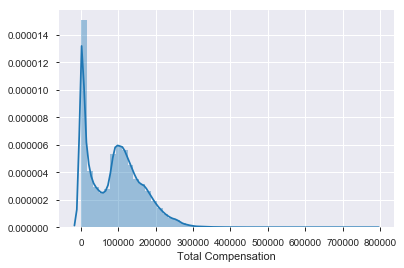

In [30]:
sns.distplot(df_clean['Total Compensation'])
plt.show()

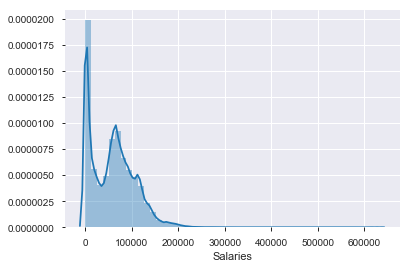

In [32]:
#Data Distribution Total Salary
import matplotlib.pyplot as plt
sns.distplot(df_clean['Total Salary'])
plt.show()

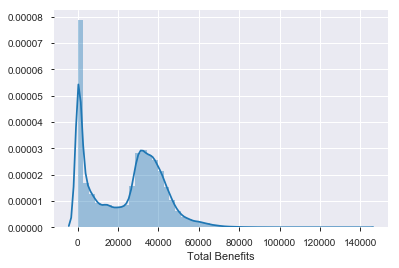

In [33]:
#Data Distribution Total Benefits
import matplotlib.pyplot as plt
sns.distplot(df_clean['Total Benefits'])
plt.show()

In [17]:
#View number of records by Organization Group
df_clean["Organization Group"].value_counts()

Public Works, Transportation & Commerce     96231
Community Health                            65625
Public Protection                           58744
General City Responsibilities               29203
Culture & Recreation                        28041
General Administration & Finance            28012
Human Welfare & Neighborhood Development    27738
Name: Organization Group, dtype: int64

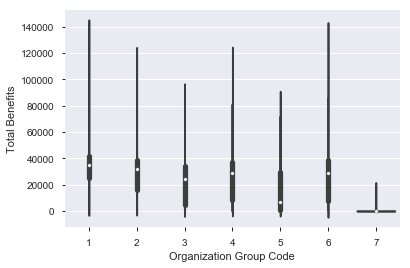

In [34]:
#Violin plot by Organization Group
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.violinplot(x="Organization Group Code", y="Total Benefits", data=df_clean, size=10)
plt.show()

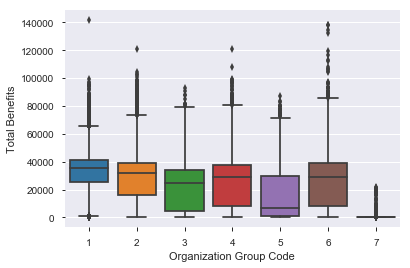

In [35]:
# Boxplot Total Compensation by Organization Group
sns.boxplot(x="Organization Group Code", y="Total Benefits", data=df_clean)

C:\Users\mtran\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


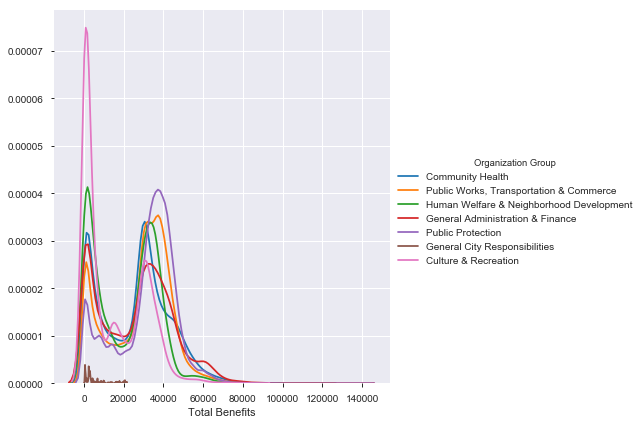

In [36]:
sns.FacetGrid(df_clean, hue="Organization Group", size=6) \
.map(sns.kdeplot, "Total Benefits") \
.add_legend()

In [20]:
#View number of records by Job Family
df_clean["Job Family"].value_counts()

Nursing                           32480
Street Transit                    27861
Police Services                   21248
Journeyman Trade                  19763
Human Services                    17306
Public Service Aide               15657
Clerical, Secretarial & Steno     14683
Fire Services                     13236
Management                        11241
Housekeeping & Laundry            10634
Budget, Admn & Stats Analysis     10203
Professional Engineering          10044
Recreation                         9832
Protection & Apprehension          9491
Correction & Detention             9006
Information Systems                8298
Legal & Court                      7525
Med Therapy & Auxiliary            7007
Payroll, Billing & Accounting      7004
Library                            6036
Lab, Pharmacy & Med Techs          5716
Personnel                          5056
Sub-Professional Engineering       4589
SF Superior Court                  4541
Semi-Skilled & General Labor       4475


C:\Users\mtran\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


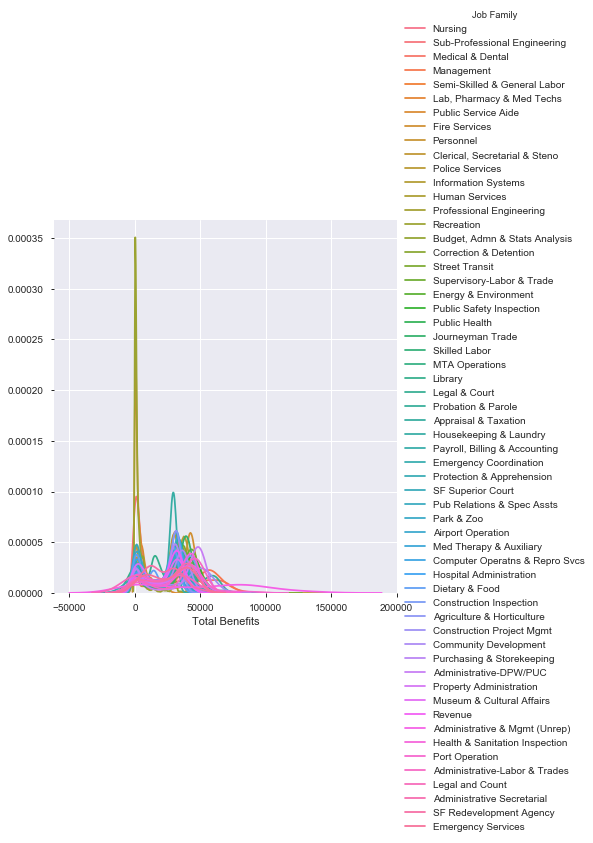

In [37]:
sns.FacetGrid(df_clean, hue="Job Family", size=6) \
.map(sns.kdeplot, "Total Benefits") \
.add_legend()

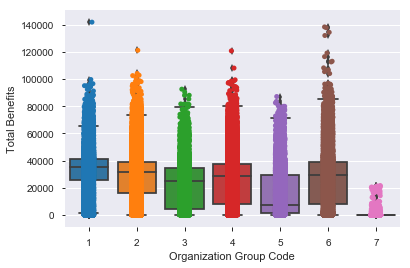

In [39]:
# One way we can extend this plot is adding a layer of individual points on top of
# it through Seaborn's striplot
# 
# We'll use jitter=True so that all the points don't fall in single vertical lines
# above the species
#
# Saving the resulting axes as ax each time causes the resulting plot to be shown
# on top of the previous axes
ax = sns.boxplot(x="Organization Group Code", y="Total Benefits", data=df_clean)
ax = sns.stripplot(x="Organization Group Code", y="Total Benefits", data=df_clean, jitter=True, edgecolor="gray")

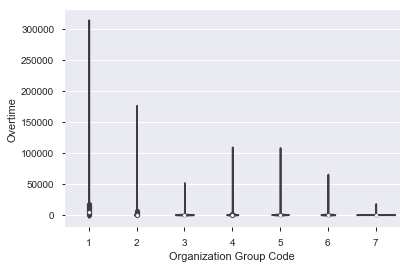

In [41]:
#Boxplot Organization Group to view most overtime
sns.violinplot(x="Organization Group Code", y="Overtime", data=df_clean, size=15)
plt.show()

C:\Users\mtran\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


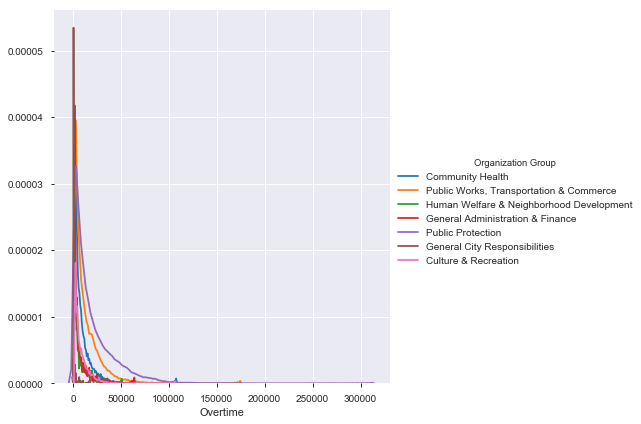

In [43]:
sns.FacetGrid(df_clean, hue="Organization Group", size=6) \
.map(sns.kdeplot, "Overtime") \
.add_legend()

In [45]:
#Subset only 2018 data
df2_clean= df_clean[df_clean.Year == 2018]
df2_clean.describe()

,Year,Organization Group Code,Union Code,Employee Identifier,Salaries,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Other Benefits,Total Benefits,Total Compensation
count,74589.0,74589.000000,74589.000000,7.458900e+04,74589.000000,74589.000000,74589.000000,74589.000000,74589.000000,74589.000000,74589.000000,74589.000000,74589.000000
mean,2018.0,4.534342,480.828715,8.549948e+06,41655.306791,3508.760368,1884.240730,47048.307889,7947.155497,5627.036558,3150.147823,16724.339878,63772.647766
std,0.0,2.318869,329.951148,3.340431e+04,49256.017388,10768.186945,5391.425864,56484.024768,9889.728405,6418.404643,4249.212177,19206.478166,74892.987277
min,2018.0,1.000000,1.000000,8.490090e+06,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2018.0,2.000000,236.000000,8.517835e+06,356.600000,0.000000,0.000000,400.130000,0.000000,0.000000,0.000000,0.000000,403.050000
50%,2018.0,5.000000,535.000000,8.553110e+06,15804.600000,0.000000,15.700000,17303.180000,675.700000,0.000000,1127.640000,3371.560000,21873.670000
75%,2018.0,7.000000,790.000000,8.578812e+06,76225.000000,616.500000,1130.000000,84562.940000,14981.910000,13733.000000,5643.110000,34242.710000,119187.530000
max,2018.0,7.000000,990.000000,8.620003e+06,537847.860000,309897.200000,187686.390000,537847.860000,98677.060000,17274.770000,37198.600000,137817.670000,675665.530000


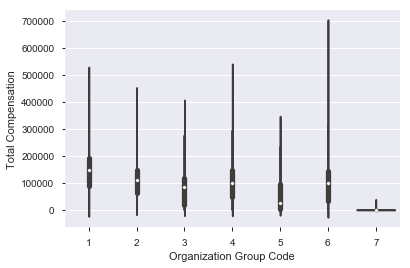

In [46]:
#Violin plot Organization GroupCode in year 2018
import seaborn as sns
sns.violinplot(x="Organization Group Code", y="Total Compensation", data=df2_clean, size=10)

In [48]:
#Prepare df for parallel_coordinates plots
#Remove object type variables, leave only Organization Group to prepare for parallel_coordinates plots

#From the Pearson corr plot in pandas_profiling, Total Salary, Salaries, and Total Compensation are highly correlated,
#keeping only Total Salary
#Other Benefits and Total Benefits are also highly correlated thus also removed

#df3 uses Organization Group Code as target with 2018 data float varaibles except target integer
#removing other highly correlated variables
df3_clean=df2_clean
df3_clean.drop(['Year', 'Organization Group', 'Union', 'Job Family', 'Job','Employee Identifier','Salaries','Total Compensation','Other Benefits'], axis=1, inplace=True)
df3_clean.head()

C:\Users\mtran\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


,Year Type,Organization Group Code,Department Code,Department,Union Code,Job Family Code,Job Code,Overtime,Other Salaries,Total Salary,Retirement,Health and Dental,Total Benefits
46665,Fiscal,2,DPW,DPW GSA - Public Works,21.0,6300,6319,0.00,0.00,63568.64,11931.77,7537.43,24619.77
46666,Fiscal,4,DPH,DPH Public Health,790.0,2600,2618,458.66,693.04,29794.00,5370.03,7303.71,14962.19
46667,Fiscal,2,AIR,AIR Airport Commission,790.0,2700,2708,1921.30,3301.86,64523.16,12050.93,13863.97,31061.21
46668,Fiscal,1,CRT,CRT Superior Court,792.0,SCRT,420C,0.00,5164.04,5164.04,0.00,0.00,395.04
46669,Fiscal,2,DPW,DPW GSA - Public Works,261.0,3400,3417,2732.83,2809.60,56850.30,10366.83,8957.32,23883.56


C:\Users\mtran\AppData\Local\Continuum\anaconda3\lib\site-packages\seaborn\axisgrid.py:2065: UserWarning: The `size` parameter has been renamed to `height`; pleaes update your code.
  warnings.warn(msg, UserWarning)
C:\Users\mtran\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\mtran\AppData\Local\Continuum\anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\mtran\AppData\Local\Continuum\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


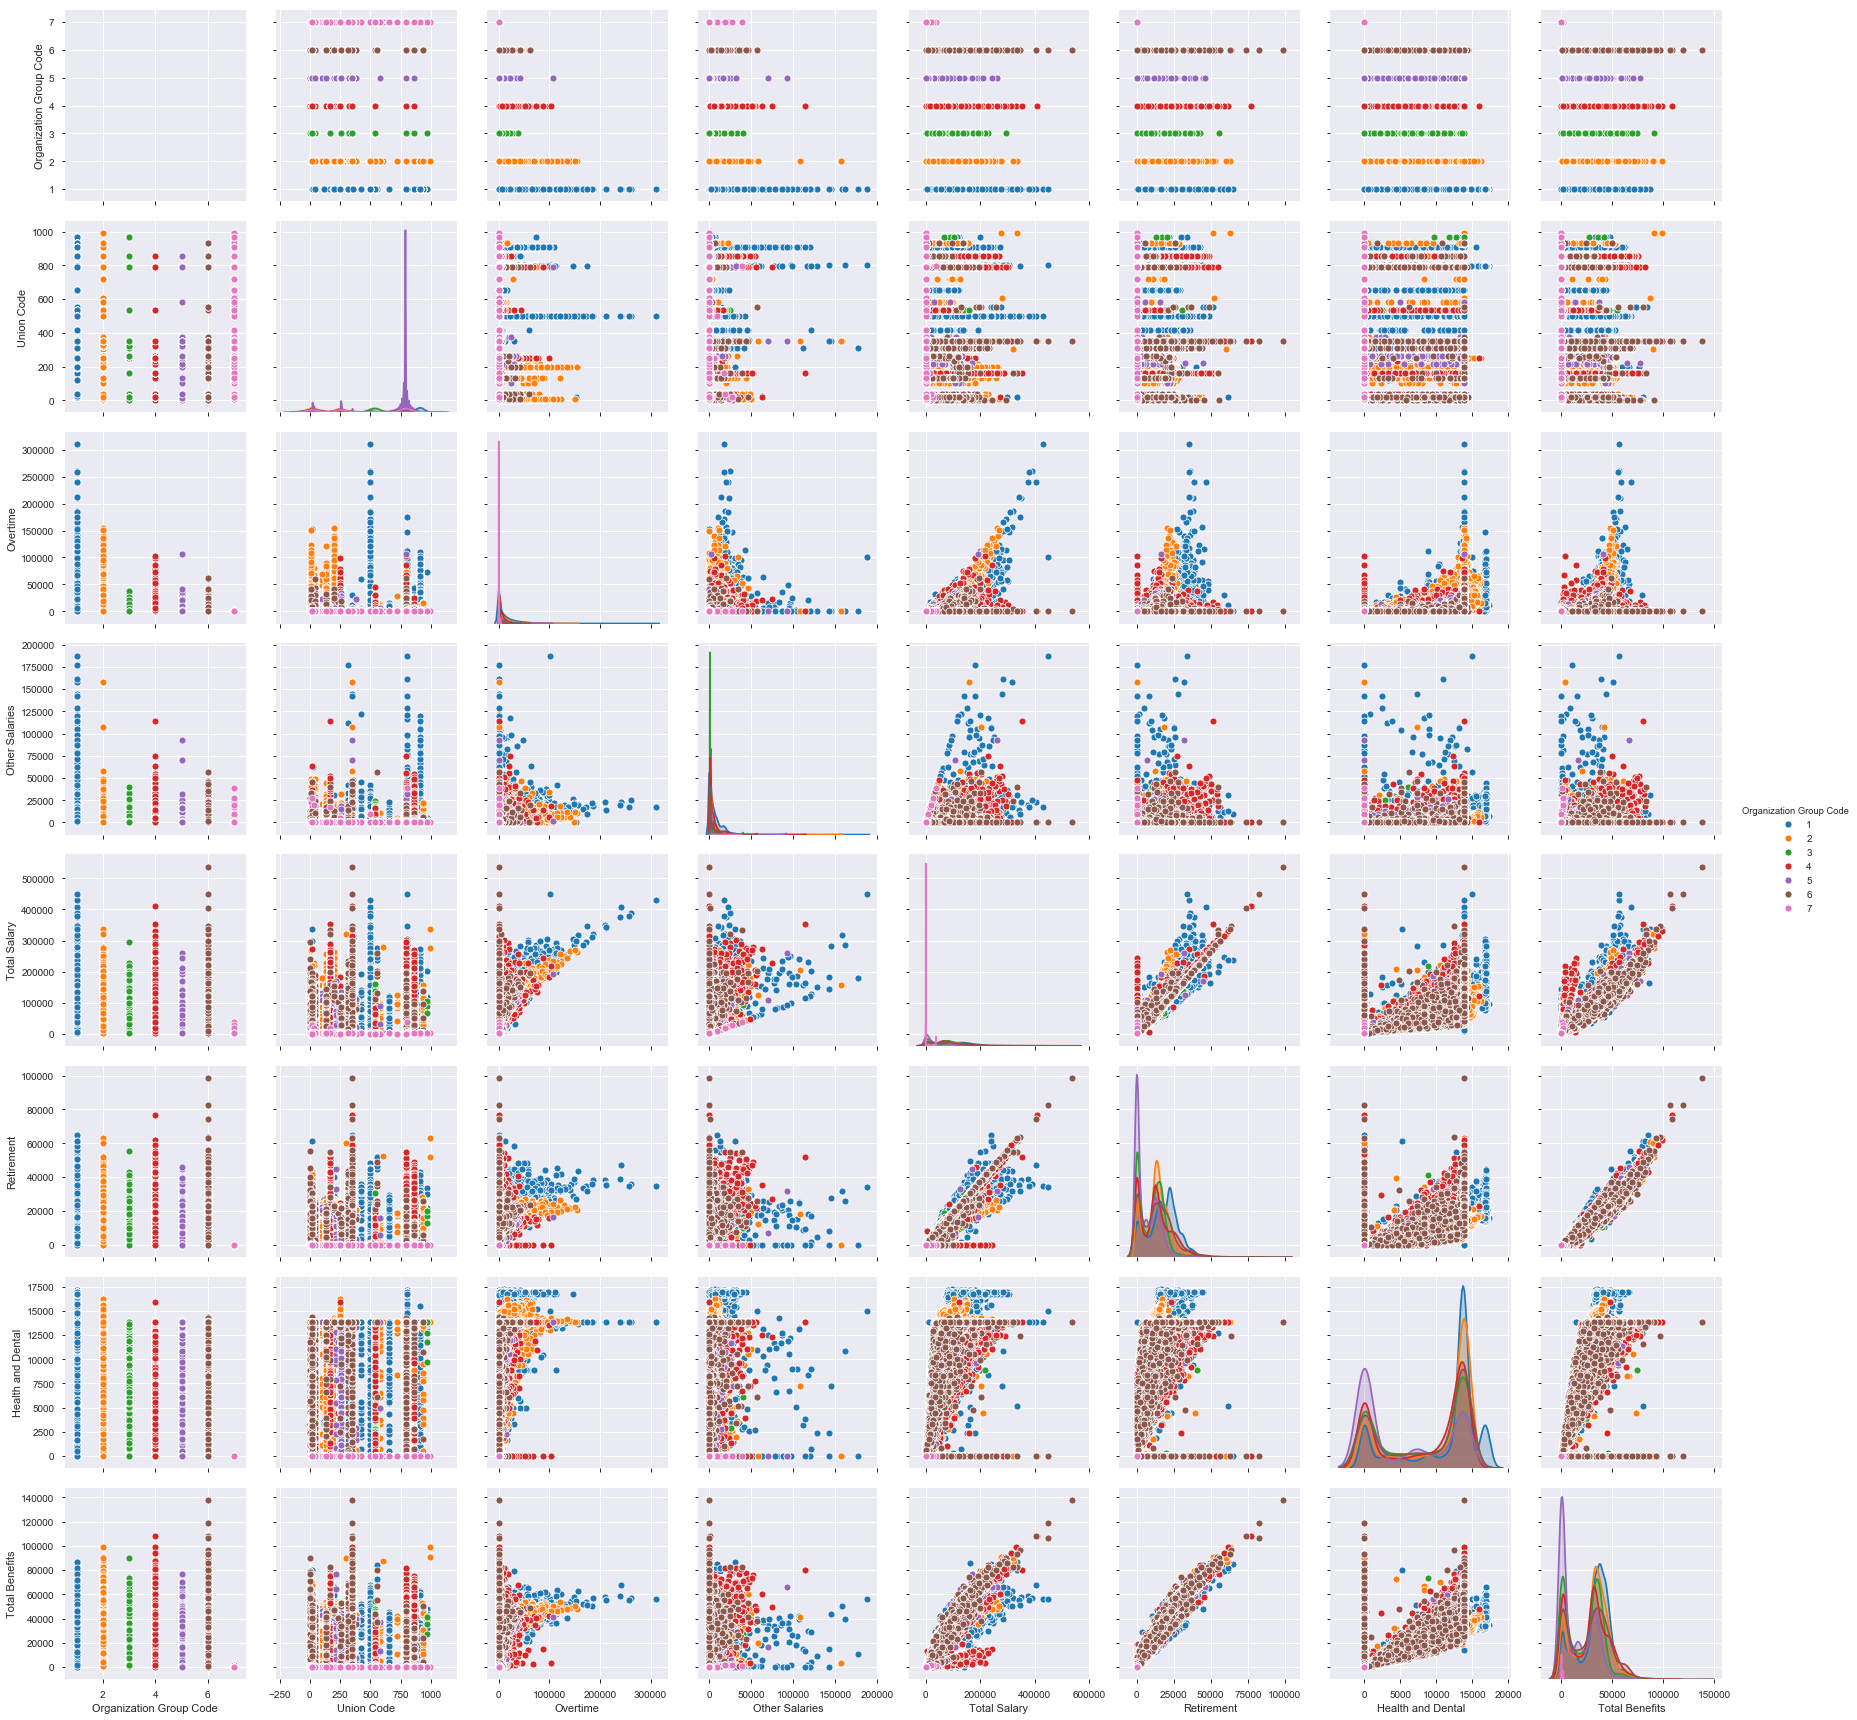

In [49]:
sns.pairplot(df3_clean, hue="Organization Group Code", size=3)

In [51]:
#Normalize the reduced df3 to prepare for parallel_coordinates plots
#Methods for Scaling data:

df4=df3_clean
# 1. Min-max scaling
df_norm_MinMax = (df4 - df4.min()) / (df4.max() - df4.min())

#normal scaling (0 mean 1 sd scaling)
df_norm_musigma = (df4 - df4.mean()) / (df4.std())

df_norm_medsigma = (df4 - df4.median()) / (df4.std())

ValueError: operands could not be broadcast together with shapes (372945,) (5,) 

In [ ]:
df_norm_MinMax.head()

In [ ]:
df_norm_musigma.head()

In [ ]:
#always need too long to run and need to shutdown kernel, so save for later
#second try: took > 40 mins to run this plot

from pandas.plotting import andrews_curves
andrews_curves(df_norm_MinMax,"Organization Group Code")

In [ ]:
andrews_curves(df_norm_musigma,"Organization Group Code")

In [ ]:
#48mins, slower when have other tasks running on computer
parallel_coordinates(df_norm_musigma,"Organization Group Code")

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
df_norm_MinMax.plot.box()
plt.show()
#how to make text labels vertical so that can see???

In [ ]:
#try to make text labels vertical
#plt.xticks(rotation='vertical')  #plt.xticks(rotation=90)
#plt.plot(np.random.randn(100).cumsum())
#plt.plot(df_norm_MinMax)
#this code below worked 
df_norm_MinMax.plot.box()
plt.xticks(rotation = 90)

In [ ]:
#%matplotlib inline #need to add this line if want to display the plot
df_norm_musigma.plot.box()
plt.xticks(rotation = 90)

In [ ]:
df_norm_medsigma.plot.box()

In [ ]:
#PCA by Organization Group Code
# reading data from the sklearn
#
from sklearn.preprocessing import StandardScaler
features = ['Overtime', 'Other Salaries', 'Total Salary', 'Retirement','Health and Dental','Total Benefits']
# Separating out the features
x = df3_clean.loc[:, features].values
# Separating out the target
y = df3_clean.loc[:,['Organization Group Code']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x=pd.DataFrame(x)

In [ ]:
x.head

In [ ]:
print(x.describe())

In [ ]:
import sklearn
from sklearn.decomposition import PCA
pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
finalDf = pd.concat([principalDf, data_df4[['Organization Group Code']]], axis = 1)

In [ ]:
#principalDf.head()
finalDf.head()

In [ ]:
names=["pca1","pca2","target"]
finalDf.columns=names
finalDf.head()
color=finalDf.target.astype("category").cat.codes

fig = plt.figure(figsize = (8,8))
plt.scatter(finalDf.pca1, finalDf.pca2,s=50,c=color,cmap='viridis')

plt.xlabel(names[0],fontsize = 15)
plt.ylabel(names[1], fontsize = 15)
plt.title('2 D PCA', fontsize = 15)

plt.grid()

In [ ]:
finalDf.plot(kind="scatter", x="pca1", y="pca2",s=50,c=color,cmap='viridis')
plt.grid()
plt.xlabel(names[0],fontsize = 15)
plt.ylabel(names[1], fontsize = 15)
plt.title('2 D PCA', fontsize = 15)
#finalDf.plot()

#my questoin:what are the color coding? what are the differences between this plot and plot above?
#interpret the results:


In [ ]:
#pca by Job Family

#create df5 to use (all years)

df5=df_clean
df5.drop(['Year Type', 'Department Code', 'Department', 'Union Code', 'Job Code','Year', 'Organization Group','Organization Group Code', 'Union', 'Job Family', 'Job','Employee Identifier','Salaries','Total Compensation','Other Benefits'], axis=1, inplace=True)

df5.head()

In [ ]:
df5.dtypes

In [ ]:
#PCA by Job Family Code
# reading data from the sklearn
#
from sklearn.preprocessing import StandardScaler
features = ['Overtime', 'Other Salaries', 'Total Salary', 'Retirement','Health and Dental','Total Benefits']
# Separating out the features
x = df5.loc[:, features].values
# Separating out the target
y = df5.loc[:,['Job Family Code']].values
# Standardizing the features
x = StandardScaler().fit_transform(x)
x=pd.DataFrame(x)

In [ ]:

pca = PCA(n_components=2)
principalComponents = pca.fit_transform(x)
principalDf = pd.DataFrame(data = principalComponents
             , columns = ['principal component 1', 'principal component 2'])

In [ ]:
finalDf = pd.concat([principalDf, df5[['Job Family Code']]], axis = 1)

In [ ]:
names=["pca1","pca2","target"]
finalDf.columns=names
finalDf.head()
color=finalDf.target.astype("category").cat.codes

fig = plt.figure(figsize = (8,8))
plt.scatter(finalDf.pca1, finalDf.pca2,s=50,c=color,cmap='viridis')

plt.xlabel(names[0],fontsize = 15)
plt.ylabel(names[1], fontsize = 15)
plt.title('2 D PCA', fontsize = 15)

plt.grid()

In [ ]:
finalDf.plot(kind="scatter", x="pca1", y="pca2",s=50,c=color,cmap='viridis')
plt.grid()
plt.xlabel(names[0],fontsize = 15)
plt.ylabel(names[1], fontsize = 15)
plt.title('2 D PCA', fontsize = 15)
#finalDf.plot()
#do not see any linear separation. may use rf for classification